In [1]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [2]:
path = Config().data_path()/'mnist'

In [3]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')

(50000, 784)

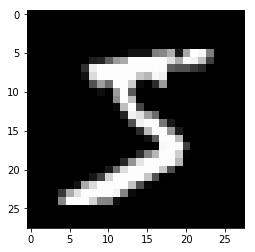

In [4]:
plt.imshow(x_train[0].reshape((28,28)), cmap="gray")
x_train.shape

In [6]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  """Entry point for launching an IPython kernel.


(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [7]:
bs=64
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)

In [13]:
x,y = next(iter(data.train_dl))
x.shape,y.shape

(torch.Size([64, 784]), torch.Size([64]))

In [14]:
#This is a subclass in python

class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin = nn.Linear(784, 10, bias=True)

    def forward(self, xb): 
        return self.lin(xb)

In [15]:
model = Mnist_Logistic().cuda()

In [16]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [17]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [18]:
model(x).shape

torch.Size([64, 10])

In [19]:
[p.shape for p in model.parameters()]

[torch.Size([10, 784]), torch.Size([10])]

In [20]:
lr=2e-2

In [21]:
loss_func = nn.CrossEntropyLoss()

In [23]:
torch.no_grad?

In [40]:
def update(model,loss_func,x,y,lr,wd = 1e-5):
    y_hat = model(x)
    # weight decay
    w2 = 0.
    #make w2 as the sum of the weights for the model
    for p in model.parameters(): 
        w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    #pytorch method to calculate the gradient
    loss.backward()
    with torch.no_grad(): #turns off the torch type to run faster
        for p in model.parameters():
            p.sub_(lr * p.grad) #sub means subtration and _ means inplace
            p.grad.zero_() #zero the gradient - specific to PyTorch
    return loss.item()

# Reason to zero the gradient
# Since the backward() function accumulates gradients, 
# and you don’t want to mix up gradients between minibatches, 
# you have to zero them out at the start of a new minibatch. 
# This is exactly like how a general (additive) accumulator 
# variable is initialized to 0 in code.

In [41]:
losses = [update(model,loss_func,x,y,lr) for x,y in data.train_dl]

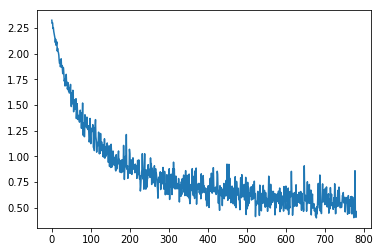

In [42]:
plt.plot(losses);

In [43]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [44]:
model = Mnist_NN().cuda()

In [45]:
losses = [update(model,loss_func,x,y,lr) for x,y in data.train_dl]

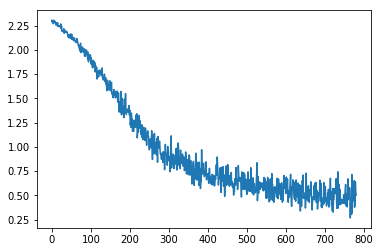

In [46]:
plt.plot(losses);

In [47]:
model = Mnist_NN().cuda()

In [49]:
def update(model,loss_func,x,y,lr):
    opt = optim.Adam(model.parameters(), lr)
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [50]:
losses = [update(model,loss_func,x,y,lr=1e-3) for x,y in data.train_dl]

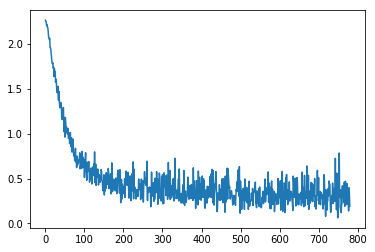

In [51]:
plt.plot(losses);

In [52]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


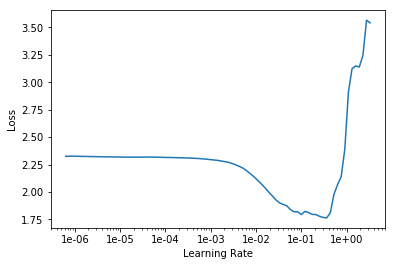

In [53]:
learn.lr_find()
learn.recorder.plot()

In [54]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.129342,0.125969,0.964900,00:03


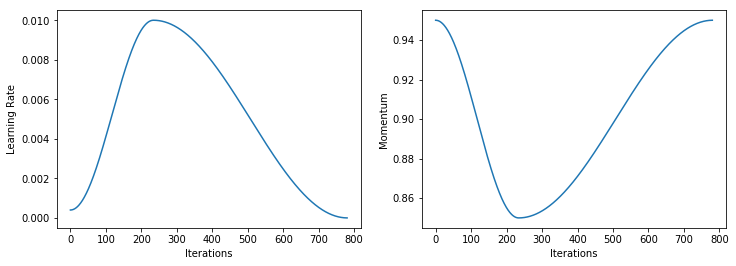

In [55]:
learn.recorder.plot_lr(show_moms=True)

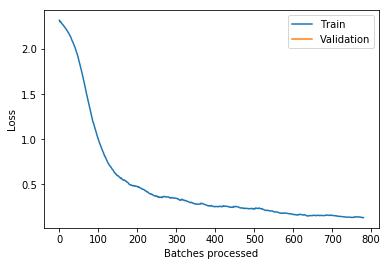

In [56]:
learn.recorder.plot_losses()

## fin